In [224]:
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
import scienceplots
import itertools
import seaborn as sns

In [225]:
plt.style.use(['science', 'ieee'])

In [284]:
def get_test_name(res_dir):
    filepath = f"../results/{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"
    with open(filepath) as file:
        name = file.read().strip()
    return name

def list_results_directories():
    path = "../"
    return [(res_dir, get_test_name(res_dir)) for res_dir in os.listdir(path) if res_dir.startswith("results-")]

def plot_smt(df_off, df_on, x, y, xlabel, ylabel, ylim=[0, 26]):
    ax = df_off.plot(
        x=x, y=y,
        xlabel=xlabel, ylabel=ylabel,
        color='blue', style='-', marker='x', ms=3,
        label="SMT OFF"
    )
    ax = df_on.plot(
        ax=ax,
        x=x, y=y,
        xlabel=xlabel, ylabel=ylabel,
        color='red', style='-', marker='o', ms=3,
        label="SMT ON", grid=True, ylim=ylim,
    )

def plot_multi(dfs, x, ys, xlabel, ylabel, dfs_labels, colors, styles, markers, ylim=[0, 26]):
    ax = dfs[0].plot(
        x=x, y=ys[0],
        xlabel=xlabel, ylabel=ylabel,
        color=colors[0], style=styles[0], marker=markers[0], ms=3,
        label=dfs_labels[0]
    )
    for df, y, label, color, style, marker in list(zip(dfs, ys, dfs_labels, colors, styles, markers))[1:]:
        ax = df.plot(
            ax=ax,
            x=x, y=y,
            xlabel=xlabel, ylabel=ylabel,
            color=color, style=style, marker=marker, ms=3,
            label=label, grid=True, ylim=ylim,
        )

def plot_percore(df, client, label):
    df = df[df.client == client]

    df.plot.bar(
        x='core', y='used', ylim=[0, 100], label=label,
        xlabel='CPU Core', ylabel='CPU Usage Percentage', grid=False)

In [285]:
res_dirs = list_results_directories()

In [286]:
res_path = '../results'

results = os.listdir(res_path)
res_dirs = {r: f"{res_path}/{r}" for r in os.listdir('../results')}

In [287]:
res_dirs

{'upload-wq': '../results/upload-wq',
 'download': '../results/download',
 'upload': '../results/upload',
 'upload-threaded': '../results/upload-threaded',
 'upload-threaded-pinned': '../results/upload-threaded-pinned',
 'download-threaded': '../results/download-threaded',
 'download-wq': '../results/download-wq',
 'download-threaded-pinned': '../results/download-threaded-pinned'}

In [288]:
def read_throughput(path):
    net = pd.read_csv(path)
    net[['rxkB/s', 'txkB/s']] *= 8e-6
    net['client'] *= 10
    
    net_wg = net[net.iface == 'wg']
    net_phy = net[net.iface == "eno1"]
    
    keep = ['cpu', 'client']
    t = net_wg.groupby(keep + ['run']).mean(numeric_only=True).reset_index()
    net = t.groupby(keep).mean(numeric_only=True).reset_index()
    net = net[net.cpu == 36]
    return net

def read_cpu(path):
    cpu = pd.read_csv(path)
    
    cpu['used'] = 100 - cpu['idle']
    cpu['client'] *= 10

    keep = ['cpu', 'client', 'core']
    t = cpu.groupby(keep + ['run']).mean(numeric_only=True).reset_index()
    cpu_df = t.groupby(keep).mean(numeric_only=True).reset_index()
    
    cpu_global = cpu_df[cpu_df.core == -1]
    cpu_global = cpu_global[cpu_global.cpu == 36]
    
    cpu_percore = cpu_df[cpu_df.core != -1]
    cpu_percore = cpu_percore[cpu_percore.cpu == 36]
    
    return cpu_global, cpu_percore

def read_latency(path):
    latency_df = []
    metric = 'latency'
    files = [i for i in os.listdir(path) if i.startswith(metric)]
    for i, file in enumerate(files):
        latency = pd.read_csv(
            f"{path}/{file}",
            names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
            skiprows=1
        )
        # print(latency.dtypes)
        latency[['mean', 'median', '90th', '99th', 'std']] *= 1e-3

        keep = ['cpu', 'client']
        t = latency.groupby(keep + ['run']).mean(numeric_only=True).reset_index()
        lat_df = t.groupby(keep).mean(numeric_only=True).reset_index()

        lat_df['node'] = i
        latency_df.append(lat_df)
    latency_df = pd.concat(latency_df, axis=0)
    keep = ['cpu', 'client']
    t = latency_df.groupby(keep + ['run']).mean(numeric_only=True).reset_index()
    lat_df = t.groupby(keep).mean(numeric_only=True).reset_index()
    lat_36 = lat_df[lat_df.cpu == 36]
    
    return lat_36

In [231]:
mode = ''
up_res = f"upload{mode}"
down_res = f"download{mode}"

In [289]:
variants = {
    '': 'baseline', 
    '-threaded': 'threaded',
    '-threaded-pinned': 'threaded-pinned', 
    '-wq': 'wq'
}
cases = ['upload', 'download']

throuhgputs = []
net_dfs = {}
latencies = []
lat_dfs = {}
cpus = []
cpu_dfs = {}
percore_cpus = []

for case, variant in list(itertools.product(cases, variants.keys())):
    truc = case + variant
    t = read_throughput(f"{res_dirs[truc]}/summary/server/throughput-sar.csv")
    t['variant'] = variants[variant]
    t['case'] = case
    throuhgputs.append(t)
    net_dfs[case, variant] = t
    
    cpu, percpu = read_cpu(f"{res_dirs[truc]}/summary/server/cpu-sar.csv")
    cpu['variant'] = variants[variant]
    cpu['case'] = case
    percpu['variant'] = variants[variant]
    percpu['case'] = case
    cpus.append(cpu)
    percore_cpus.append(percpu)
    cpu_dfs[case, variant] = cpu
    
    t = read_latency(f"{res_dirs[truc]}/summary/clients")
    t['variant'] = variants[variant]
    t['case'] = case
    latencies.append(t)
    lat_dfs[case, variant] = t

throuhgput = pd.concat(throuhgputs, axis=0)
latency = pd.concat(latencies, axis=0)
cpu = pd.concat(cpus, axis=0)
percore_cpu = pd.concat(percore_cpus, axis=0)

In [233]:
up_net = throuhgput[throuhgput.case == 'upload']
down_net = throuhgput[throuhgput.case == 'download']

In [234]:
up_net.head()

,cpu,client,run,rxpck/s,txpck/s,rxkB/s,txkB/s,variant,case
1,36,10,2.0,2.747351e+04,14810.470611,0.311118,0.011178,baseline,upload
2,36,100,2.0,2.057366e+05,122591.288889,2.333084,0.092601,baseline,upload
3,36,300,2.0,6.188265e+05,368979.833333,7.017550,0.278730,baseline,upload
4,36,500,2.0,1.034689e+06,619650.527778,11.733467,0.468178,baseline,upload
5,36,800,2.0,4.142382e+05,150516.652111,4.692968,0.115048,baseline,upload


In [235]:
up_nets = [net_dfs['upload', i] for i in variants.keys()]
up_nets_labels = list(variants.values())
colors = ['black', 'green', 'red', 'blue']
markers = ['x', 'o', 's', 'p']

up_nets.reverse()
up_nets_labels.reverse()

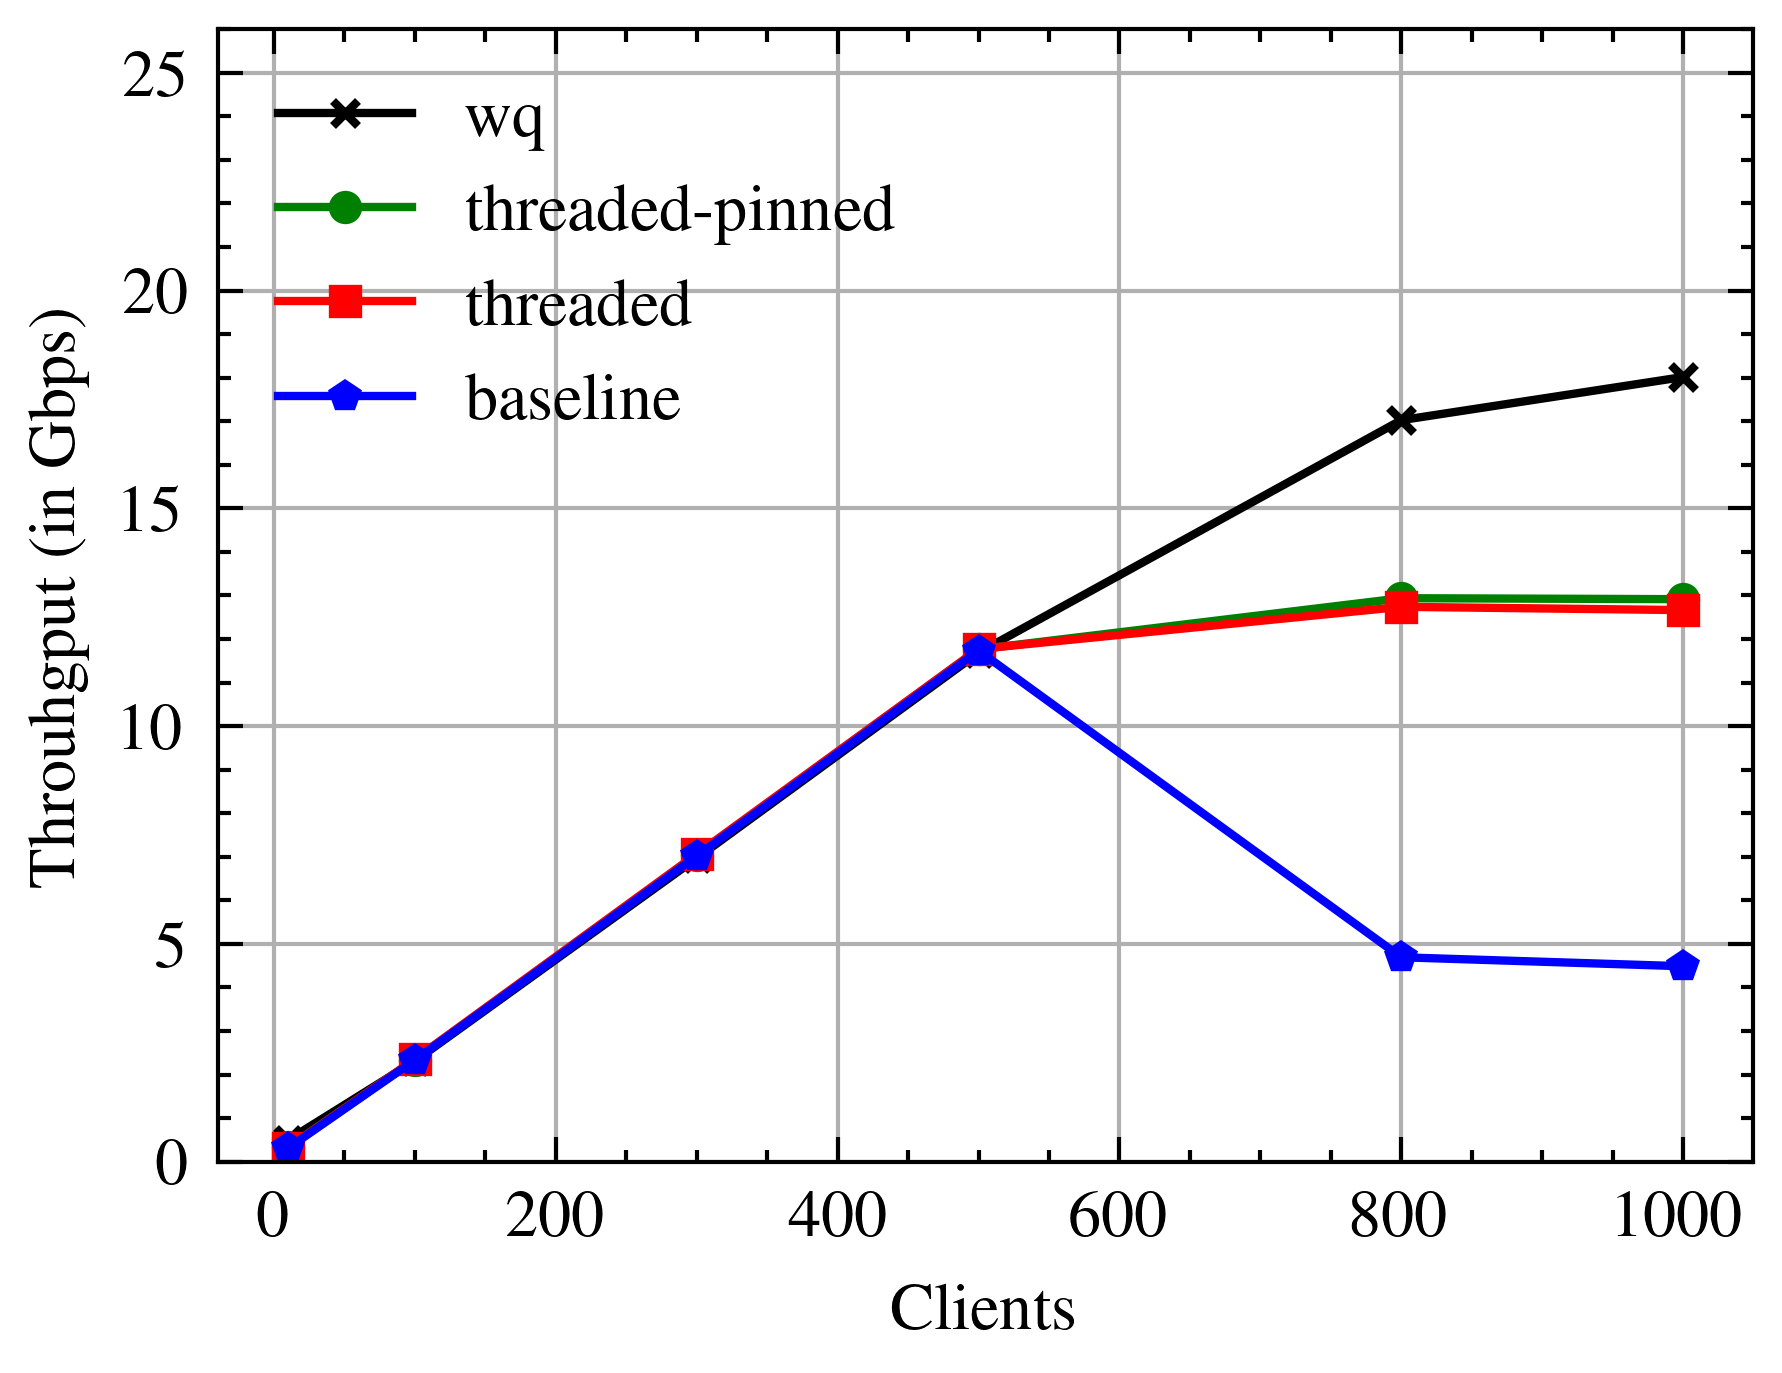

In [237]:
plot_multi(up_nets, x='client', ys=['rxkB/s']*4, xlabel='Clients', ylabel='Throuhgput (in Gbps)', dfs_labels=up_nets_labels, colors=colors, styles=['-']*4, markers=markers,)

In [301]:
ups = [lat_dfs['upload', i] for i in variants.keys()]
up_labels = list(variants.values())

ups.reverse()
up_labels.reverse()

colors = ['black', 'green', 'red', 'blue']
variant_colors = {i: c for i, c in zip(variants.keys(), colors) }
markers = ['x', 'o', 's', 'p']
variant_markers = {i: c for i, c in zip(variants.keys(), markers) }

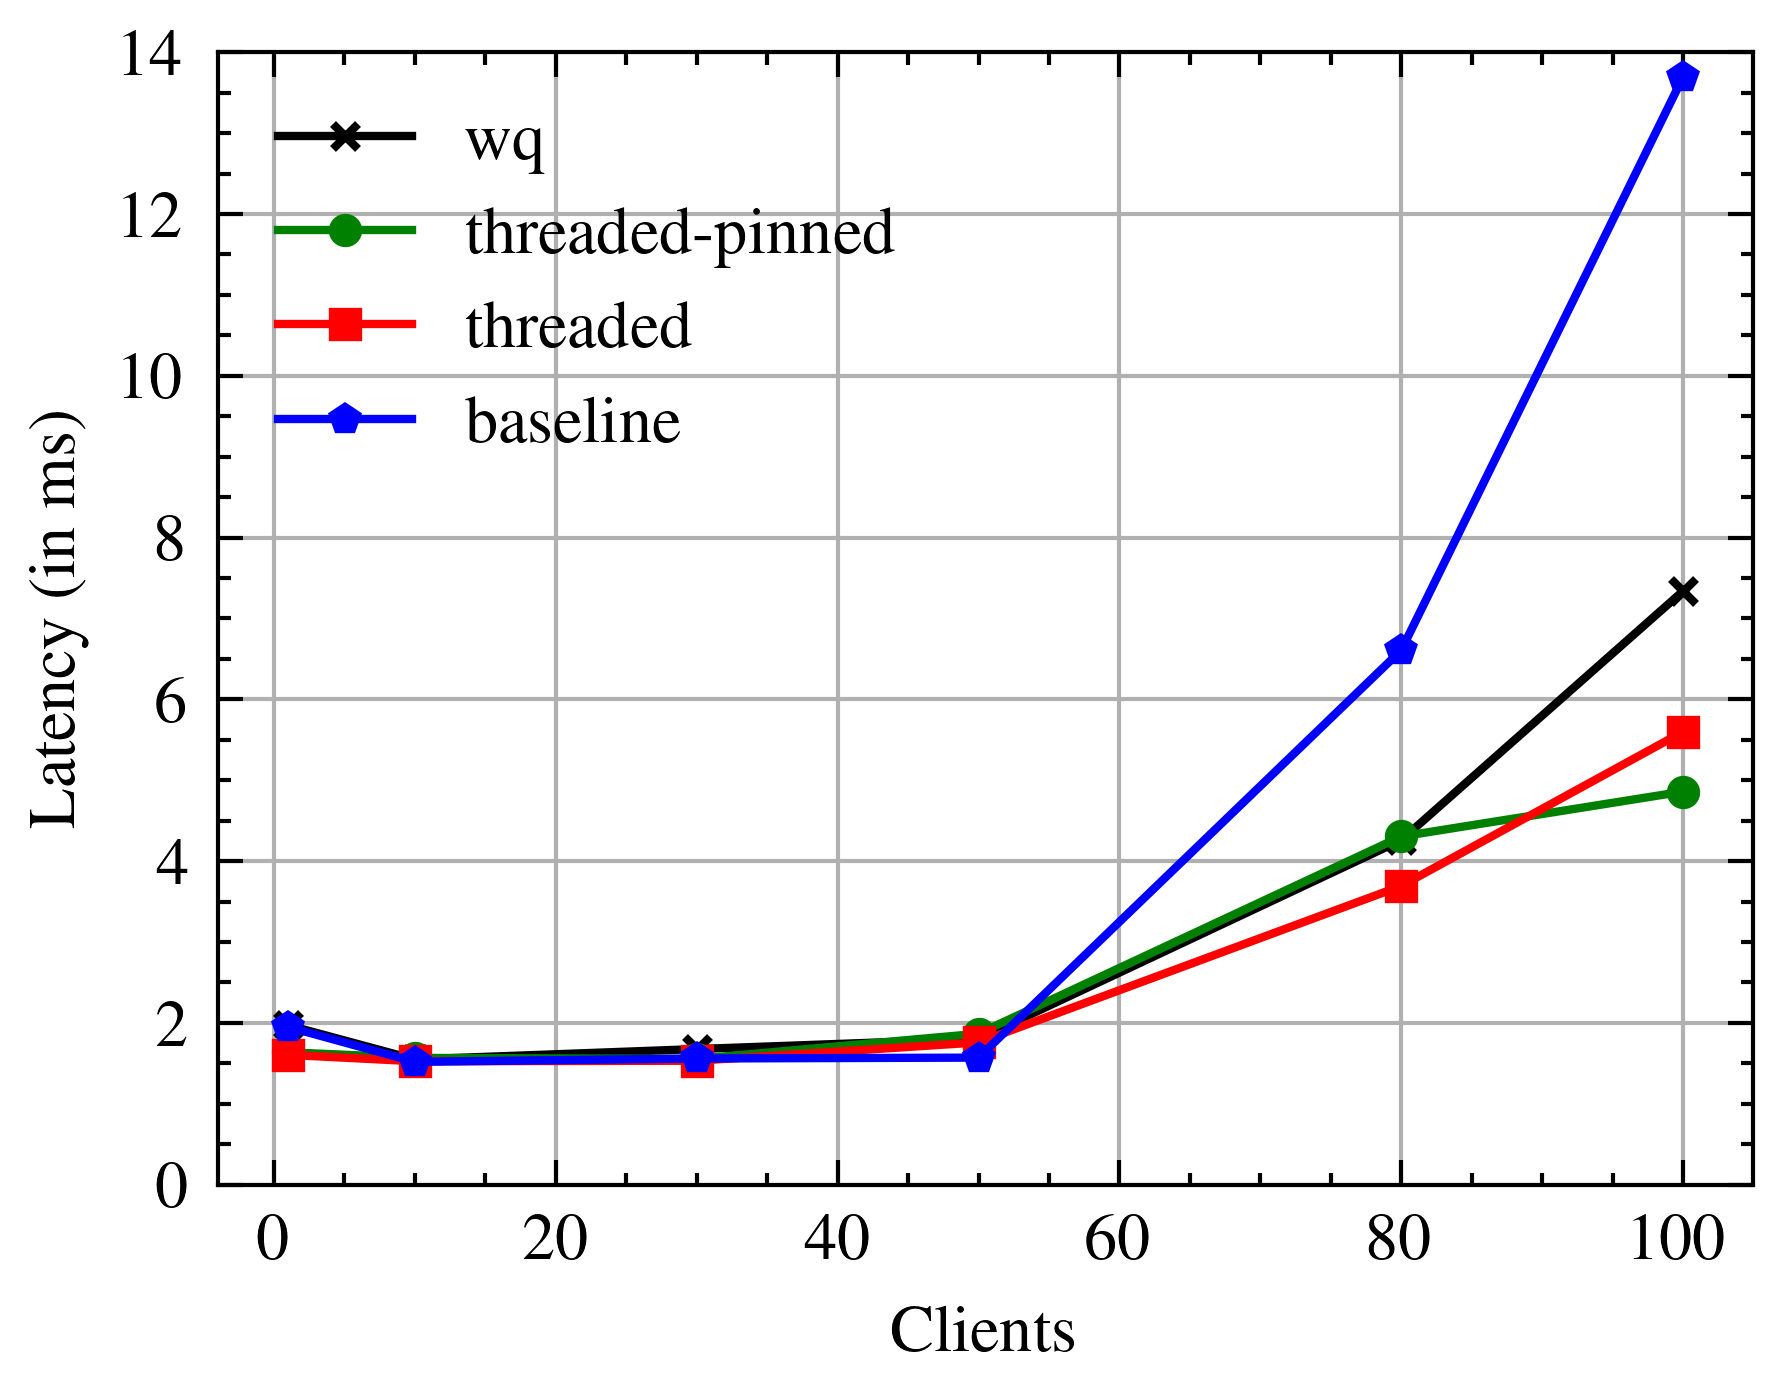

In [259]:
plot_multi(ups, x='client', ys=['99th']*4, xlabel='Clients', ylabel='Latency (in ms)', dfs_labels=up_labels, colors=colors, styles=['-']*4, markers=markers, ylim=[0, 14])

In [293]:
list(itertools.product(cases, variants.keys()))

[('upload', ''),
 ('upload', '-threaded'),
 ('upload', '-threaded-pinned'),
 ('upload', '-wq'),
 ('download', ''),
 ('download', '-threaded'),
 ('download', '-threaded-pinned'),
 ('download', '-wq')]

In [294]:
boths = {}
for case, variant in itertools.product(cases, variants.keys()):
    x = lat_dfs[case, variant]
    y = net_dfs[case, variant].reset_index(drop=True)
    x['client'] *= 10

    boths[case, variant] = pd.merge(x, y, on=['cpu', 'client', 'variant', 'case', 'run'])

In [295]:
boths['upload', '']

,cpu,client,run,node,min,mean,median,90th,99th,max,std,variant,case,rxpck/s,txpck/s,rxkB/s,txkB/s
0,36,10,2.0,4.5,532.933333,4.573857,1.247600,1.950067,1.950067,35170.733333,10.271176,baseline,upload,2.747351e+04,14810.470611,0.311118,0.011178
1,36,100,2.0,4.5,430.333333,5.698590,1.177603,1.518273,1.518273,47390.903333,14.022820,baseline,upload,2.057366e+05,122591.288889,2.333084,0.092601
2,36,300,2.0,4.5,424.862222,5.041848,1.118512,1.559946,1.559946,41085.725556,12.137340,baseline,upload,6.188265e+05,368979.833333,7.017550,0.278730
3,36,500,2.0,4.5,443.068000,5.252626,1.128263,1.570765,1.570765,43152.142667,12.744603,baseline,upload,1.034689e+06,619650.527778,11.733467,0.468178
4,36,800,2.0,4.5,508.722083,5.762014,1.761697,6.606785,6.606785,35950.140833,11.014318,baseline,upload,4.142382e+05,150516.652111,4.692968,0.115048
5,36,1000,2.0,4.5,965.773000,8.028901,2.637261,13.693211,13.693211,40109.574000,12.627868,baseline,upload,3.962199e+05,141177.783333,4.486949,0.108334


In [305]:
variants

{'': 'baseline',
 '-threaded': 'threaded',
 '-threaded-pinned': 'threaded-pinned',
 '-wq': 'wq'}

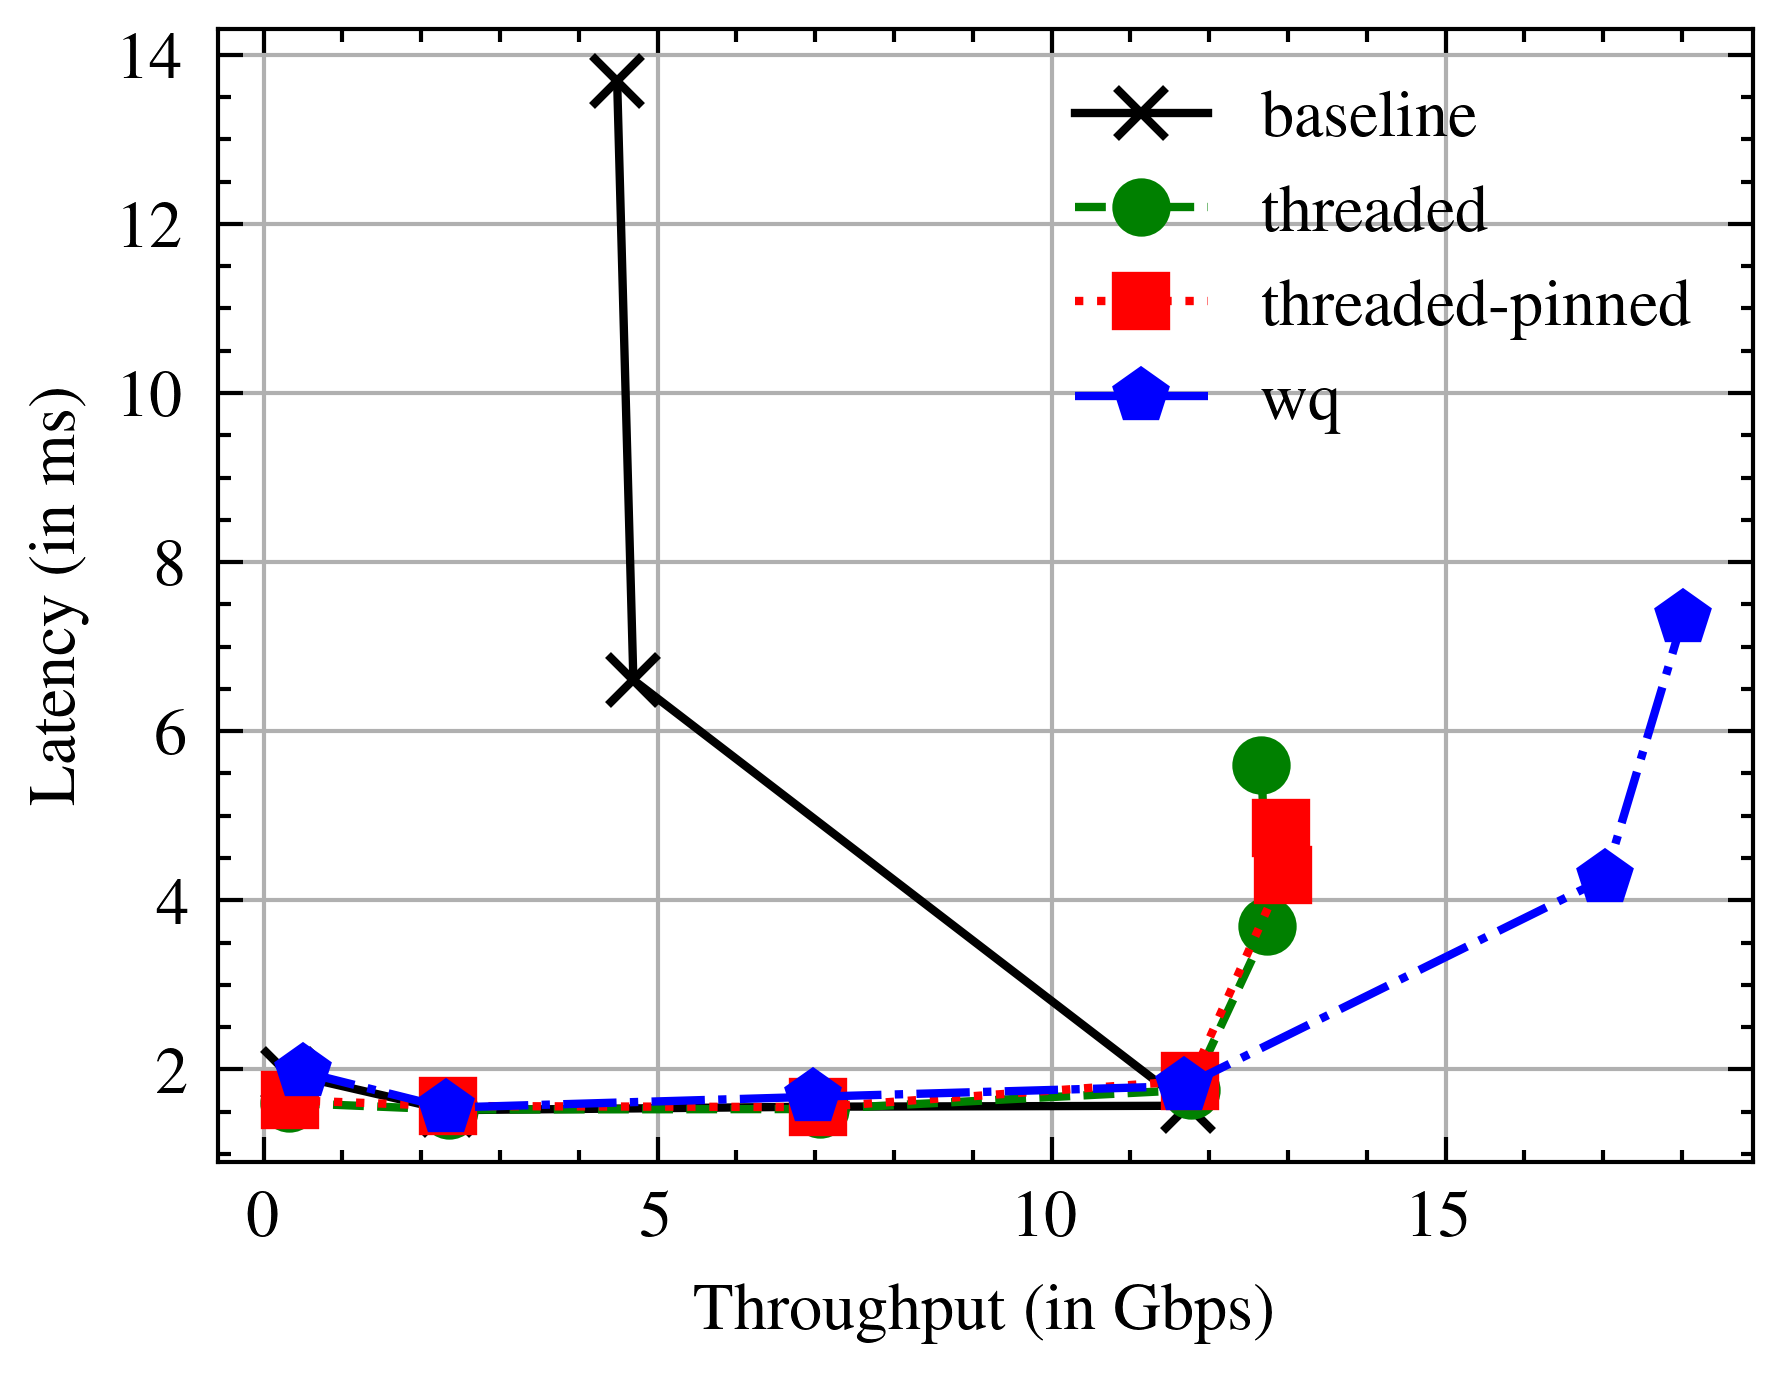

In [ ]:
v = ''
ax = boths['upload', v].plot(
    x='rxkB/s', y='99th', color=variant_colors[v], marker=variant_markers[v], grid=True, xlabel='Throughput (in Gbps)', ylabel='Latency (in ms)', label=variants[v])
for v in list(variants.keys())[1:]:
    boths['upload', v].plot( ax=ax,
    x='rxkB/s', y='99th', color=variant_colors[v], marker=variant_markers[v], grid=True, xlabel='Throughput (in Gbps)', ylabel='Latency (in ms)', label=variants[v])

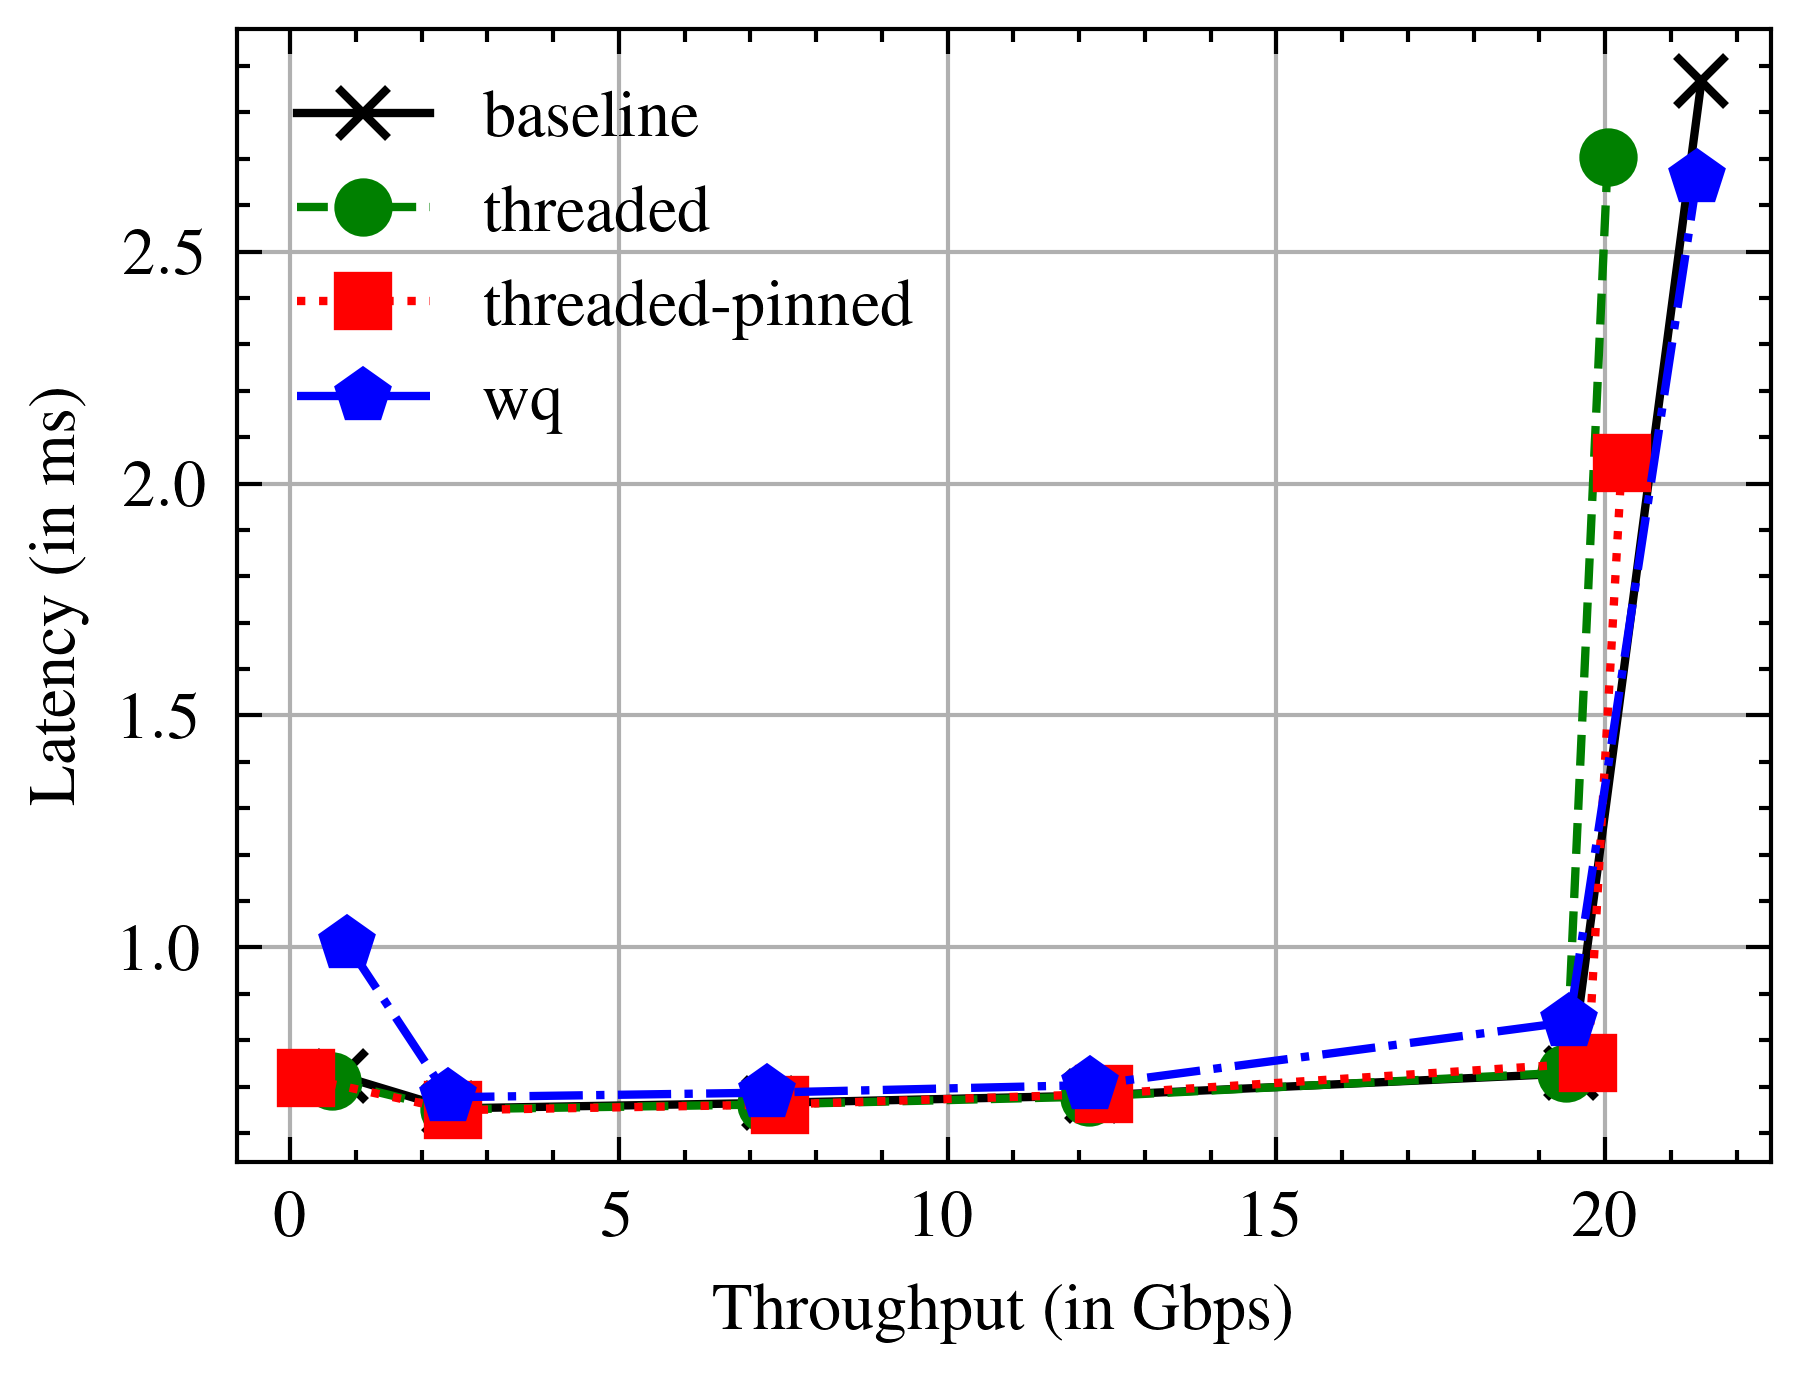

In [310]:
v = ''
case = 'download'
ax = boths[case, v].plot(
    x='txkB/s', y='99th', color=variant_colors[v], marker=variant_markers[v], grid=True, xlabel='Throughput (in Gbps)', ylabel='Latency (in ms)', label=variants[v])
for v in list(variants.keys())[1:]:
    boths[case, v].plot( ax=ax,
    x='txkB/s', y='99th', color=variant_colors[v], marker=variant_markers[v], grid=True, xlabel='Throughput (in Gbps)', ylabel='Latency (in ms)', label=variants[v])

In [238]:
# sns.lineplot(data=up_net, x='client', y='rxkB/s', hue='variant')
# plt.grid(True)
# plt.xlabel('Clients')
# plt.ylabel('Throuhgput')
# plt.ylim([0, 25])
# plt.show()

In [239]:
# sns.lineplot(data=down_net, x='client', y='txkB/s', hue='variant')
# plt.grid(True)
# plt.xlabel('Clients')
# plt.ylabel('Throuhgput')
# plt.ylim([0, 25])
# plt.show()

In [240]:
# 

In [241]:
# 

In [242]:
# 

In [243]:
# 

In [244]:
# up = read_throughput(f"{res_dirs[up_res]}/summary/server/throughput-sar.csv")
# down = read_throughput(f"{res_dirs[down_res]}/summary/server/throughput-sar.csv")

In [245]:
# plot_multi(dfs=[down, up], x='client', ys=['txkB/s', 'rxkB/s'],
#         xlabel="Number of clients", ylabel="Throughput", dfs_labels=['Download', 'Upload'], colors=['red', 'blue'], styles=['-', '-'], markers=['x', 'o'], ylim=[0, 25])

In [246]:
# 

In [247]:
# up, percore_up = read_cpu(f"{res_dirs[up_res]}/summary/server/cpu-sar.csv")
# down, percore_down = read_cpu(f"{res_dirs[down_res]}/summary/server/cpu-sar.csv")

In [248]:
# plot_multi(dfs=[down, up], x='client', ys=['used', 'used'],
#         xlabel="Number of clients", ylabel="CPU Usage Percentage", dfs_labels=['Download', 'Upload'], colors=['red', 'blue'], styles=['-', '-'], markers=['x', 'o'], ylim=[0, 100])

In [249]:
# 

In [250]:
# up = read_latency(f"{res_dirs[up_res]}/summary/clients")
# down = read_latency(f"{res_dirs[down_res]}/summary/clients")

In [251]:
# plot_multi(
#     dfs=[down, up], x='client', ys=['99th', '99th'],
#     xlabel="Number of clients", ylabel="Latency (in ms)", dfs_labels=['Download', 'Upload'], colors=['red', 'blue'], styles=['-', '-'], markers=['x', 'o'], ylim=[0, 15])

In [ ]:
# 